In [1]:
import sys
sys.path.insert(0, '/users/junzheyin/iris/src')
print(sys.path)

['/users/junzheyin/iris/src', '/users/junzheyin/iris/src/models/tokenizer', '/users/junzheyin/anaconda3/envs/iris/lib/python38.zip', '/users/junzheyin/anaconda3/envs/iris/lib/python3.8', '/users/junzheyin/anaconda3/envs/iris/lib/python3.8/lib-dynload', '', '/users/junzheyin/.local/lib/python3.8/site-packages', '/users/junzheyin/anaconda3/envs/iris/lib/python3.8/site-packages']


In [2]:
from dataclasses import dataclass
from typing import Any, Tuple

from einops import rearrange
import torch
import torch.nn as nn

#from dataset import Batch
from lpips import LPIPS
from nets import Encoder, Decoder
from utils import LossWithIntermediateLosses

batch=1
@dataclass
class TokenizerEncoderOutput:
    z: torch.FloatTensor
    z_quantized: torch.FloatTensor
    tokens: torch.LongTensor


class Tokenizer(nn.Module):
    def __init__(self, vocab_size: int, embed_dim: int, encoder: Encoder, decoder: Decoder, with_lpips: bool) -> None:
        super().__init__()
        self.vocab_size = vocab_size
        self.encoder = encoder
        self.pre_quant_conv = torch.nn.Conv2d(encoder.config.z_channels, embed_dim, 1)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.post_quant_conv = torch.nn.Conv2d(embed_dim, decoder.config.z_channels, 1)
        self.decoder = decoder
        self.embedding.weight.data.uniform_(-1.0 / vocab_size, 1.0 / vocab_size)
        self.lpips = LPIPS().eval() if with_lpips else None

    def __repr__(self) -> str:
        return "tokenizer"

    def forward(self, x: torch.Tensor, should_preprocess: bool = False, should_postprocess: bool = False) -> Tuple[torch.Tensor]:
        outputs = self.encode(x, should_preprocess)
        decoder_input = outputs.z + (outputs.z_quantized - outputs.z).detach()
        reconstructions = self.decode(decoder_input, should_postprocess)
        return outputs.z, outputs.z_quantized, reconstructions

    def compute_loss(self, x, **kwargs: Any) -> LossWithIntermediateLosses:
        assert self.lpips is not None
        observations = x
        z, z_quantized, reconstructions = self(observations, should_preprocess=False, should_postprocess=False)

        # Codebook loss. Notes:
        # - beta position is different from taming and identical to original VQVAE paper
        # - VQVAE uses 0.25 by default
        beta = 1.0
        commitment_loss = (z.detach() - z_quantized).pow(2).mean() + beta * (z - z_quantized.detach()).pow(2).mean()

        reconstruction_loss = torch.abs(observations - reconstructions).mean()
        perceptual_loss = torch.mean(self.lpips(observations, reconstructions))

        return LossWithIntermediateLosses(commitment_loss=commitment_loss, reconstruction_loss=reconstruction_loss,perceptual_loss=perceptual_loss)

    def encode(self, x: torch.Tensor, should_preprocess: bool = False) -> TokenizerEncoderOutput:
        if should_preprocess:
            x = self.preprocess_input(x)
        #print("Shape of x:", x.shape)
        shape = x.shape  # (..., C, H, W)
        x = x.view(-1, *shape[-3:])
        #print("Shape of x as (x_view):", x.shape)
        z = self.encoder(x)
        #print("Shape of z:",z.shape)
        z = self.pre_quant_conv(z)
        b, e, h, w = z.shape
        z_flattened = rearrange(z, 'b e h w -> (b h w) e')
        #print("Shape of z_flattend:",z_flattened.shape)
        dist_to_embeddings = torch.sum(z_flattened ** 2, dim=1, keepdim=True) + torch.sum(self.embedding.weight**2, dim=1) - 2 * torch.matmul(z_flattened, self.embedding.weight.t())

        tokens = dist_to_embeddings.argmin(dim=-1)
        #print("Shape of tokens:",tokens.shape)
        z_q = rearrange(self.embedding(tokens), '(b h w) e -> b e h w', b=b, e=e, h=h, w=w).contiguous()
        #print("Shape of z_q:",z_q.shape)
        # Reshape to original
        z = z.reshape(*shape[:-3], *z.shape[1:])
        #print("Shape of reshaped z:", z.shape)
        z_q = z_q.reshape(*shape[:-3], *z_q.shape[1:])
        #print("Shape of reshaped z_q:", z_q.shape)
        tokens = tokens.reshape(*shape[:-3], -1)
        #print("Shape of tokens:", tokens.shape)

        return TokenizerEncoderOutput(z, z_q, tokens)

    def decode(self, z_q: torch.Tensor, should_postprocess: bool = False) -> torch.Tensor:
        shape = z_q.shape  # (..., E, h, w)
        z_q = z_q.view(-1, *shape[-3:])
        z_q = self.post_quant_conv(z_q)
        rec = self.decoder(z_q)
        rec = rec.reshape(*shape[:-3], *rec.shape[1:])
        if should_postprocess:
            rec = self.postprocess_output(rec)
        return rec

    @torch.no_grad()
    def encode_decode(self, x: torch.Tensor, should_preprocess: bool = False, should_postprocess: bool = False) -> torch.Tensor:
        z_q = self.encode(x, should_preprocess).z_quantized
        return self.decode(z_q, should_postprocess)

    def preprocess_input(self, x: torch.Tensor) -> torch.Tensor:
        """x is supposed to be channels first and in [0, 1]"""
        return x.mul(2).sub(1)

    def postprocess_output(self, y: torch.Tensor) -> torch.Tensor:
        """y is supposed to be channels first and in [-1, 1]"""
        return y.add(1).div(2)


In [3]:
from typing import List

import torch
import torch.nn as nn
## Configuration file for the Endocer and Decoder
@dataclass
class EncoderDecoderConfig:
    resolution: int
    in_channels: int
    z_channels: int
    ch: int
    ch_mult: List[int]
    num_res_blocks: int
    attn_resolutions: List[int]
    out_ch: int
    dropout: float

In [4]:
encoder = Encoder(EncoderDecoderConfig(resolution=256,
                                       in_channels=1,
                                        z_channels=512,
                                        ch=128,
                                        ch_mult= [1, 1, 1, 2, 2 ,2, 4],
                                        num_res_blocks= 2,
                                        attn_resolutions= [4],
                                        out_ch= 1,
                                        dropout= 0.0))
decoder=Decoder(EncoderDecoderConfig(resolution=256,
                                       in_channels=1,
                                        z_channels=512,
                                        ch=128,
                                        ch_mult=[1, 1, 1, 2, 2, 2, 4 ],
                                        num_res_blocks= 2,
                                        attn_resolutions= [4],
                                        out_ch= 1,
                                        dropout= 0.0))
vocab_size = 1024 # actual vocabulary size 
embed_dim = 16  # the desired embedding dimension of the codebook (coebook dim)
tokenizer = Tokenizer(vocab_size, embed_dim, encoder, decoder, with_lpips=True)
print(encoder)
print(decoder)

Tokenizer : shape of latent is (512, 4, 4).
Encoder(
  (conv_in): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down): ModuleList(
    (0): Module(
      (block): ModuleList(
        (0): ResnetBlock(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): ResnetBlock(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (attn): ModuleList

In [ ]:
# encoder = Encoder(EncoderDecoderConfig(resolution=256,
#                                        in_channels=1,
#                                         z_channels=1024,
#                                         ch=64,
#                                         ch_mult= [1,1,1,1,1],
#                                         num_res_blocks= 2,
#                                         attn_resolutions= [8, 16],
#                                         out_ch= 1,
#                                         dropout= 0.0))
# decoder = Decoder(EncoderDecoderConfig(resolution=256,
#                                        in_channels=1,
#                                         z_channels=1024,
#                                         ch=64,
#                                         ch_mult= [1,1,1,1,1],
#                                         num_res_blocks= 2,
#                                         attn_resolutions= [8, 16],
#                                         out_ch= 1,
#                                         dropout= 0.0))
# vocab_size = 1024 # actual vocabulary size 
# embed_dim = 256 # the desired embedding dimension of the codebook (codebook dim) should be equal with the z_channels
# tokenizer = Tokenizer(vocab_size, embed_dim, encoder, decoder, with_lpips=True)
# print(encoder)
# print(decoder)

In [5]:
learning_rate=0.0001 # cfg training file 
optimizer_tokenizer = torch.optim.Adam(tokenizer.parameters(), lr=learning_rate)

In [6]:
# Define dataset
import torch
import sys
#from nuwa_pytorch import VQGanVAE
import h5py
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
def eventGeneration(start_time, obs_time = 3 ,lead_time = 6, time_interval = 30):
    # Generate event based on starting time point, return a list: [[t-4,...,t-1,t], [t+1,...,t+72]]
    # Get the start year, month, day, hour, minute
    year = int(start_time[0:4])
    month = int(start_time[4:6])
    day = int(start_time[6:8])
    hour = int(start_time[8:10])
    minute = int(start_time[10:12])
    #print(datetime(year=year, month=month, day=day, hour=hour, minute=minute))
    times = [(datetime(year, month, day, hour, minute) + timedelta(minutes=time_interval * (x+1))) for x in range(lead_time)]
    lead = [dt.strftime('%Y%m%d%H%M') for dt in times]
    times = [(datetime(year, month, day, hour, minute) - timedelta(minutes=time_interval * x)) for x in range(obs_time)]
    obs = [dt.strftime('%Y%m%d%H%M') for dt in times]
    obs.reverse()
    return lead, obs

from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
from torchvision.transforms import ToTensor, Compose, CenterCrop
class radarDataset(Dataset):
    def __init__(self, root_dir, event_times, obs_number = 3, pred_number = 6, transform=None):
        # event_times is an array of starting time t(string)
        # transform is the preprocessing functions
        self.root_dir = root_dir
        self.transform = transform
        self.event_times = event_times
        self.obs_number = obs_number
        self.pred_number = pred_number
    def __len__(self):
        return len(self.event_times)
    def __getitem__(self, idx):
        start_time = str(self.event_times[idx])
        time_list_pre, time_list_obs = eventGeneration(start_time, self.obs_number, self.pred_number)
        output = []
        time_list = time_list_obs + time_list_pre
        #print(time_list)
        for time in time_list:
            year = time[0:4]
            month = time[4:6]
            #path = self.root_dir + year + '/' + month + '/' + 'RAD_NL25_RAC_MFBS_EM_5min_' + time + '_NL.h5'
            path = self.root_dir + year + '/' + month + '/' + 'RAD_NL25_RAP_5min_' + time + '.h5'
            image = np.array(h5py.File(path)['image1']['image_data'])
            #image = np.ma.masked_where(image == 65535, image)
            image = image[264:520,242:498]
            image[image == 65535] = 0
            image = image.astype('float32')
            image = image/100*12
            image = np.clip(image, 0, 128)
            image = image/40
            #image = 2*image-1 #normalize to [-1,1]
            output.append(image)
        output = torch.permute(torch.tensor(np.array(output)), (1, 2, 0))
        output = self.transform(np.array(output))
        return output
#root_dir = '/users/hbi/data/RAD_NL25_RAC_MFBS_EM_5min/'
#dataset = radarDataset(root_dir, ["200808031600"], transform = Compose([ToTensor(),CenterCrop(256)]))
#print(image.shape)

In [7]:
# develop dataset
from torch.cuda.amp import autocast
#from torch.autograd import Variable
import pandas as pd
root_dir = '/home/hbi/RAD_NL25_RAP_5min/' 

df_train = pd.read_csv('/users/hbi/taming-transformers/training_Delfland08-14_20.csv', header = None)
event_times = df_train[0].to_list()
dataset_train = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))  

df_train_s = pd.read_csv('/users/hbi/taming-transformers/training_Delfland08-14.csv', header = None)
event_times = df_train_s[0].to_list()
dataset_train_del = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))  

df_test = pd.read_csv('/users/hbi/taming-transformers/testing_Delfland18-20.csv', header = None)
event_times = df_test[0].to_list()
dataset_test = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))

df_vali = pd.read_csv('/users/hbi/taming-transformers/validation_Delfland15-17.csv', header = None)
event_times = df_vali[0].to_list()
dataset_vali = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))

df_train_aa = pd.read_csv('/users/hbi/taming-transformers/training_Aa08-14.csv', header = None)
event_times = df_train_aa[0].to_list()
dataset_train_aa = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))  

df_train_dw = pd.read_csv('/users/hbi/taming-transformers/training_Dwar08-14.csv', header = None)
event_times = df_train_dw[0].to_list()
dataset_train_dw = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))    

df_train_re = pd.read_csv('/users/hbi/taming-transformers/training_Regge08-14.csv', header = None)
event_times = df_train_re[0].to_list()
dataset_train_re = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))   

data_list = [dataset_train_aa, dataset_train_dw, dataset_train_del, dataset_train_re]
train_aadedwre = torch.utils.data.ConcatDataset(data_list)

print(len(dataset_train), len(dataset_test), len(dataset_vali))
loaders = { 'train' :DataLoader(train_aadedwre, batch_size=1, shuffle=True, num_workers=8),
            'test' :DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=8), 
           'valid' :DataLoader(dataset_vali, batch_size=1, shuffle=False, num_workers=8),
          
          'train_aa5' :DataLoader(dataset_train_aa, batch_size=1, shuffle=False, num_workers=8),
          'train_dw5' :DataLoader(dataset_train_dw, batch_size=1, shuffle=False, num_workers=8),
          'train_del5' :DataLoader(dataset_train_del, batch_size=1, shuffle=True, num_workers=8),
          'train_re5' :DataLoader(dataset_train_re, batch_size=1, shuffle=False, num_workers=8),
          }

32183 3493 3560


In [8]:
# Initializing Device as cuda:0
cuda_version = torch.version.cuda
print("CUDA version:", cuda_version)
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print("PyTorch version:", torch.__version__)

CUDA version: 11.3
True
cuda:0
PyTorch version: 1.11.0


In [9]:
checkpoint = torch.load('/space/junzheyin/check2/vqvae_checkpoint_epoch30', map_location=device)
tokenizer.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
##Training loop VQVAE 
import numpy as np
from collections import defaultdict
loss_total_step=0.0
intermediate_losses = defaultdict(float)
num_epochs=80
device = torch.device("cuda:0")  # Specify the GPU device
epoch_start=30
tokenizer.to(device)
all_metrics = []  # List to store metrics for all epochs

for epoch in range(epoch_start,num_epochs):
    save_epoch = epoch in [40, 50, 60, 70, 80, 90, 100, 110]
    #save_epoch = epoch in [2]
    loss_total_epoch=0.0
    optimizer_tokenizer.zero_grad()
    intermediate_losses = {}
    print("epoch {}".format(epoch))
    for i, images in enumerate(loaders['train']):
        loss_total_step=0.0
        image = images[0]
        image = image.unsqueeze(1)
        image = image[3:4, :, :, :]
        input_image= image.to(device)  # batch x
        #print(input_image.size())
        encoder_output = tokenizer.encode(input_image)
        losses=tokenizer.compute_loss(input_image)
        
        loss_total_step += losses.loss_total 
        loss_total_epoch += loss_total_step.item()/64
        if (i+1) % 64 == 0:
            (loss_total_step/64).backward()
            optimizer_tokenizer.step()
            optimizer_tokenizer.zero_grad()
            
            print("Losses: Total = {:.4f}".format(loss_total_step.item()))
            #loss_total_step=0.0
        

        for loss_name, loss_value in losses.intermediate_losses.items():
                intermediate_losses[f"{str(tokenizer)}/train/{loss_name}"] = loss_value/64
    
        
    metrics = {f'{str(Tokenizer)}/train/total_loss': loss_total_epoch, **intermediate_losses}
    print("Epoch {}: Total Loss = {:.4f}".format(epoch, metrics[f'{str(Tokenizer)}/train/total_loss']))

    if save_epoch:
        torch.save({
        'model_state_dict': tokenizer.state_dict(),
        'optimizer_state_dict': optimizer_tokenizer.state_dict(),
        }, '/space/junzheyin/check2/vqvae_checkpoint_epoch{}'.format(epoch+1))

    all_metrics.append(metrics)  # Save metrics for the current epoch to the list


# Convert the metrics list to a NumPy array
metrics_array = np.array(all_metrics)

# Save the metrics array as a NumPy file
np.save('/space/junzheyin/metrics/', metrics_array)
# Print all errors from each epoch's metrics dictionary
# print(all_metrics)

epoch 30
Losses: Total = 0.1473
Losses: Total = 0.1392
Losses: Total = 0.1243
Losses: Total = 0.0912
Losses: Total = 0.1744
Losses: Total = 0.1042
Losses: Total = 0.1663
Losses: Total = 0.1667
Losses: Total = 0.1576
Losses: Total = 0.3663
Losses: Total = 0.1644
Losses: Total = 0.2028
Losses: Total = 0.2516
Losses: Total = 0.2537
Losses: Total = 0.1227
Losses: Total = 0.0902
Losses: Total = 0.2789
Losses: Total = 0.3004
Losses: Total = 0.2846
Losses: Total = 0.1955
Losses: Total = 0.0859
Losses: Total = 0.1588
Losses: Total = 0.1852
Losses: Total = 0.1130
Losses: Total = 0.0445
Losses: Total = 0.1181
Losses: Total = 0.1544
Losses: Total = 0.2243
Losses: Total = 0.2724
Losses: Total = 0.3247
Losses: Total = 0.1863
Losses: Total = 0.1824
Losses: Total = 0.1482
Losses: Total = 0.2611
Losses: Total = 0.0851
Losses: Total = 0.1400
Losses: Total = 0.1260
Losses: Total = 0.1627
Losses: Total = 0.1437
Losses: Total = 0.1944
Losses: Total = 0.1550
Losses: Total = 0.1816
Losses: Total = 0.0849
Lo

Losses: Total = 0.0934
Losses: Total = 0.2820
Losses: Total = 0.0236
Losses: Total = 0.2485
Losses: Total = 0.1805
Losses: Total = 0.3349
Losses: Total = 0.2119
Losses: Total = 0.1704
Losses: Total = 0.2547
Losses: Total = 0.1965
Losses: Total = 0.1866
Losses: Total = 0.1120
Losses: Total = 0.2129
Losses: Total = 0.1171
Losses: Total = 0.1460
Losses: Total = 0.3118
Losses: Total = 0.0883
Losses: Total = 0.0596
Losses: Total = 0.1998
Losses: Total = 0.1616
Losses: Total = 0.2533
Losses: Total = 0.2002
Losses: Total = 0.2033
Losses: Total = 0.1961
Losses: Total = 0.1440
Losses: Total = 0.1174
Losses: Total = 0.0672
Losses: Total = 0.0578
Losses: Total = 0.2399
Losses: Total = 0.3214
Losses: Total = 0.3371
Losses: Total = 0.1231
Losses: Total = 0.2251
Losses: Total = 0.2333
Losses: Total = 0.3599
Losses: Total = 0.3063
Losses: Total = 0.1083
Losses: Total = 0.1359
Losses: Total = 0.0753
Losses: Total = 0.2110
Losses: Total = 0.1143
Losses: Total = 0.2218
Losses: Total = 0.1381
Losses: Tot

Losses: Total = 0.1489
Losses: Total = 0.1291
Losses: Total = 0.2024
Losses: Total = 0.1230
Losses: Total = 0.1843
Losses: Total = 0.0700
Losses: Total = 0.0942
Losses: Total = 0.2598
Losses: Total = 0.1135
Losses: Total = 0.2917
Losses: Total = 0.0424
Losses: Total = 0.0935
Losses: Total = 0.0175
Losses: Total = 0.2234
Losses: Total = 0.2930
Losses: Total = 0.2359
Losses: Total = 0.2384
Losses: Total = 0.1196
Losses: Total = 0.1203
Losses: Total = 0.1785
Losses: Total = 0.1482
Losses: Total = 0.1353
Losses: Total = 0.1087
Losses: Total = 0.2040
Losses: Total = 0.1977
Losses: Total = 0.2721
Losses: Total = 0.2458
Losses: Total = 0.2338
Losses: Total = 0.3017
Losses: Total = 0.1716
Losses: Total = 0.2789
Losses: Total = 0.2385
Losses: Total = 0.3188
Losses: Total = 0.1989
Losses: Total = 0.2240
Losses: Total = 0.0354
Losses: Total = 0.1804
Losses: Total = 0.2084
Losses: Total = 0.2305
Losses: Total = 0.2702
Losses: Total = 0.0990
Losses: Total = 0.1182
Losses: Total = 0.2393
Losses: Tot

Losses: Total = 0.1742
Losses: Total = 0.1848
Losses: Total = 0.2282
Losses: Total = 0.1149
Losses: Total = 0.2441
Losses: Total = 0.1782
Losses: Total = 0.2351
Losses: Total = 0.2196
Losses: Total = 0.2542
Losses: Total = 0.2099
Losses: Total = 0.2221
Losses: Total = 0.3129
Losses: Total = 0.3583
Losses: Total = 0.1383
Losses: Total = 0.2082
Losses: Total = 0.2685
Losses: Total = 0.1693
Losses: Total = 0.1418
Losses: Total = 0.0841
Losses: Total = 0.0390
Losses: Total = 0.2119
Losses: Total = 0.1132
Losses: Total = 0.2329
Losses: Total = 0.2947
Losses: Total = 0.2017
Losses: Total = 0.1267
Losses: Total = 0.1002
Losses: Total = 0.2115
Losses: Total = 0.0201
Losses: Total = 0.0365
Losses: Total = 0.1600
Losses: Total = 0.0909
Losses: Total = 0.0953
Losses: Total = 0.2403
Losses: Total = 0.3314
Losses: Total = 0.0660
Losses: Total = 0.0911
Losses: Total = 0.1438
Losses: Total = 0.3243
Losses: Total = 0.1453
Losses: Total = 0.3627
Losses: Total = 0.1867
Losses: Total = 0.1574
Losses: Tot

Losses: Total = 0.3255
Losses: Total = 0.2258
Losses: Total = 0.0828
Losses: Total = 0.2273
Losses: Total = 0.2101
Losses: Total = 0.1850
Losses: Total = 0.1213
Losses: Total = 0.1698
Losses: Total = 0.1272
Losses: Total = 0.3330
Losses: Total = 0.0259
Epoch 32: Total Loss = 90.2155
epoch 33
Losses: Total = 0.3736
Losses: Total = 0.1909
Losses: Total = 0.1828
Losses: Total = 0.1322
Losses: Total = 0.1003
Losses: Total = 0.2749
Losses: Total = 0.0564
Losses: Total = 0.2379
Losses: Total = 0.0403
Losses: Total = 0.1984
Losses: Total = 0.3032
Losses: Total = 0.2541
Losses: Total = 0.2491
Losses: Total = 0.2131
Losses: Total = 0.2202
Losses: Total = 0.0909
Losses: Total = 0.0922
Losses: Total = 0.0806
Losses: Total = 0.2025
Losses: Total = 0.2312
Losses: Total = 0.2057
Losses: Total = 0.2865
Losses: Total = 0.2863
Losses: Total = 0.2552
Losses: Total = 0.1537
Losses: Total = 0.0403
Losses: Total = 0.0692
Losses: Total = 0.2704
Losses: Total = 0.1814
Losses: Total = 0.1288
Losses: Total = 0

Losses: Total = 0.2218
Losses: Total = 0.2560
Losses: Total = 0.2875
Losses: Total = 0.2264
Losses: Total = 0.1397
Losses: Total = 0.2102
Losses: Total = 0.2501
Losses: Total = 0.1606
Losses: Total = 0.2383
Losses: Total = 0.2489
Losses: Total = 0.0692
Losses: Total = 0.2184
Losses: Total = 0.1788
Losses: Total = 0.1472
Losses: Total = 0.2805
Losses: Total = 0.2954
Losses: Total = 0.2230
Losses: Total = 0.2528
Losses: Total = 0.0345
Losses: Total = 0.1695
Losses: Total = 0.2164
Losses: Total = 0.0534
Losses: Total = 0.1517
Losses: Total = 0.2619
Losses: Total = 0.0876
Losses: Total = 0.1544
Losses: Total = 0.2248
Losses: Total = 0.0519
Losses: Total = 0.3213
Losses: Total = 0.2947
Losses: Total = 0.1441
Losses: Total = 0.0925
Losses: Total = 0.3084
Losses: Total = 0.0427
Losses: Total = 0.1142
Losses: Total = 0.1642
Losses: Total = 0.1865
Losses: Total = 0.2117
Losses: Total = 0.2763
Losses: Total = 0.1043
Losses: Total = 0.1899
Losses: Total = 0.1130
Losses: Total = 0.2112
Losses: Tot

Losses: Total = 0.0941
Losses: Total = 0.1183
Losses: Total = 0.2318
Losses: Total = 0.2943
Losses: Total = 0.2130
Losses: Total = 0.2725
Losses: Total = 0.1613
Losses: Total = 0.1954
Losses: Total = 0.2781
Losses: Total = 0.1815
Losses: Total = 0.1713
Losses: Total = 0.1827
Losses: Total = 0.2100
Losses: Total = 0.1680
Losses: Total = 0.1761
Losses: Total = 0.1657
Losses: Total = 0.1049
Losses: Total = 0.1567
Losses: Total = 0.2656
Losses: Total = 0.1461
Losses: Total = 0.3566
Losses: Total = 0.1890
Losses: Total = 0.2005
Losses: Total = 0.1420
Losses: Total = 0.3606
Losses: Total = 0.2557
Losses: Total = 0.2113
Losses: Total = 0.1338
Losses: Total = 0.1814
Losses: Total = 0.2681
Losses: Total = 0.1293
Losses: Total = 0.1934
Losses: Total = 0.2219
Losses: Total = 0.2481
Losses: Total = 0.2047
Losses: Total = 0.2307
Losses: Total = 0.1752
Losses: Total = 0.2389
Losses: Total = 0.1899
Losses: Total = 0.2379
Losses: Total = 0.2325
Losses: Total = 0.1023
Losses: Total = 0.1406
Losses: Tot

Losses: Total = 0.1698
Losses: Total = 0.3053
Losses: Total = 0.2201
Losses: Total = 0.2486
Losses: Total = 0.1570
Losses: Total = 0.2307
Losses: Total = 0.0850
Losses: Total = 0.2107
Losses: Total = 0.0930
Losses: Total = 0.1529
Losses: Total = 0.1733
Losses: Total = 0.0690
Losses: Total = 0.1721
Losses: Total = 0.0975
Losses: Total = 0.0754
Losses: Total = 0.2011
Losses: Total = 0.2452
Losses: Total = 0.3336
Losses: Total = 0.2179
Losses: Total = 0.4323
Losses: Total = 0.1063
Losses: Total = 0.2509
Losses: Total = 0.2787
Losses: Total = 0.1655
Losses: Total = 0.2287
Losses: Total = 0.1362
Losses: Total = 0.2213
Losses: Total = 0.1968
Losses: Total = 0.2280
Losses: Total = 0.2546
Losses: Total = 0.1590
Losses: Total = 0.0667
Losses: Total = 0.2568
Losses: Total = 0.2167
Losses: Total = 0.1474
Losses: Total = 0.0557
Losses: Total = 0.1599
Losses: Total = 0.0909
Losses: Total = 0.1869
Losses: Total = 0.1308
Losses: Total = 0.2137
Losses: Total = 0.1744
Losses: Total = 0.0674
Losses: Tot

Losses: Total = 0.0391
Losses: Total = 0.2737
Losses: Total = 0.1745
Losses: Total = 0.1647
Losses: Total = 0.0574
Losses: Total = 0.1602
Losses: Total = 0.2401
Losses: Total = 0.2048
Losses: Total = 0.1023
Losses: Total = 0.0277
Losses: Total = 0.1604
Losses: Total = 0.1301
Losses: Total = 0.2393
Losses: Total = 0.2057
Losses: Total = 0.2873
Losses: Total = 0.1477
Losses: Total = 0.0162
Losses: Total = 0.2770
Losses: Total = 0.3106
Losses: Total = 0.1683
Losses: Total = 0.1794
Losses: Total = 0.1562
Losses: Total = 0.0853
Epoch 35: Total Loss = 90.1086
epoch 36
Losses: Total = 0.2253
Losses: Total = 0.2608
Losses: Total = 0.2498
Losses: Total = 0.2265
Losses: Total = 0.1454
Losses: Total = 0.1406
Losses: Total = 0.0726
Losses: Total = 0.1542
Losses: Total = 0.0782
Losses: Total = 0.1449
Losses: Total = 0.3285
Losses: Total = 0.2311
Losses: Total = 0.3071
Losses: Total = 0.1285
Losses: Total = 0.2084
Losses: Total = 0.1761
Losses: Total = 0.1763
Losses: Total = 0.2238
Losses: Total = 0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Losses: Total = 0.3022
Losses: Total = 0.1258
Losses: Total = 0.2331
Losses: Total = 0.1635
Losses: Total = 0.1323
Losses: Total = 0.2768
Losses: Total = 0.1999
Losses: Total = 0.2388
Losses: Total = 0.2246
Losses: Total = 0.1524
Losses: Total = 0.0587
Losses: Total = 0.0981
Losses: Total = 0.1740
Losses: Total = 0.3351
Losses: Total = 0.3473
Losses: Total = 0.2202
Losses: Total = 0.2487
Losses: Total = 0.3083
Losses: Total = 0.2994
Losses: Total = 0.3313
Losses: Total = 0.1408
Losses: Total = 0.1889
Losses: Total = 0.1196
Losses: Total = 0.2880
Losses: Total = 0.3184
Losses: Total = 0.2471
Losses: Total = 0.0677
Losses: Total = 0.3160
Losses: Total = 0.1665
Losses: Total = 0.0494
Losses: Total = 0.1092
Losses: Total = 0.1202
Losses: Total = 0.2557
Losses: Total = 0.1953
Losses: Total = 0.2910
Losses: Total = 0.2005
Losses: Total = 0.2853
Losses: Total = 0.2048
Losses: Total = 0.3185
Losses: Total = 0.2413
Losses: Total = 0.1139
Losses: Total = 0.2419
Losses: Total = 0.2200
Losses: Tot

Losses: Total = 0.1853
Losses: Total = 0.1264
Losses: Total = 0.1482
Losses: Total = 0.1134
Losses: Total = 0.2393
Losses: Total = 0.1547
Losses: Total = 0.0733
Losses: Total = 0.1345
Losses: Total = 0.2316
Losses: Total = 0.1825
Losses: Total = 0.3379
Losses: Total = 0.2427
Losses: Total = 0.1130
Losses: Total = 0.1102
Losses: Total = 0.3366
Losses: Total = 0.3163
Losses: Total = 0.0893
Losses: Total = 0.1610
Losses: Total = 0.1806
Losses: Total = 0.1419
Losses: Total = 0.2742
Losses: Total = 0.1675
Losses: Total = 0.1636
Losses: Total = 0.1445
Losses: Total = 0.2430
Losses: Total = 0.0345
Losses: Total = 0.2169
Losses: Total = 0.2021
Losses: Total = 0.1783
Losses: Total = 0.2130
Losses: Total = 0.2002
Losses: Total = 0.1852
Losses: Total = 0.1083
Losses: Total = 0.2773
Losses: Total = 0.2633
Losses: Total = 0.0611
Losses: Total = 0.2001
Losses: Total = 0.1421
Losses: Total = 0.2616
Losses: Total = 0.1808
Losses: Total = 0.1357
Losses: Total = 0.1587
Losses: Total = 0.1297
Losses: Tot

Losses: Total = 0.2751
Losses: Total = 0.1401
Losses: Total = 0.2568
Losses: Total = 0.2389
Losses: Total = 0.1563
Losses: Total = 0.2061
Losses: Total = 0.1686
Losses: Total = 0.1923
Losses: Total = 0.1321
Losses: Total = 0.1951
Losses: Total = 0.1849
Losses: Total = 0.1445
Losses: Total = 0.2377
Losses: Total = 0.2537
Losses: Total = 0.1089
Losses: Total = 0.1931
Losses: Total = 0.2177
Losses: Total = 0.0657
Losses: Total = 0.1633
Losses: Total = 0.2788
Losses: Total = 0.2233
Losses: Total = 0.2718
Losses: Total = 0.2177
Losses: Total = 0.1411
Losses: Total = 0.2066
Losses: Total = 0.1349
Losses: Total = 0.1410
Losses: Total = 0.1923
Losses: Total = 0.2477
Losses: Total = 0.1538
Losses: Total = 0.1510
Losses: Total = 0.0651
Losses: Total = 0.2548
Losses: Total = 0.2550
Losses: Total = 0.1897
Losses: Total = 0.2014
Losses: Total = 0.1840
Losses: Total = 0.1676
Losses: Total = 0.1514
Losses: Total = 0.1070
Losses: Total = 0.2658
Losses: Total = 0.1854
Losses: Total = 0.2420
Losses: Tot

Losses: Total = 0.1828
Losses: Total = 0.2372
Losses: Total = 0.3163
Losses: Total = 0.2775
Losses: Total = 0.1981
Losses: Total = 0.2079
Losses: Total = 0.2252
Losses: Total = 0.1372
Losses: Total = 0.3096
Losses: Total = 0.1581
Losses: Total = 0.1364
Losses: Total = 0.1661
Losses: Total = 0.0889
Losses: Total = 0.1444
Losses: Total = 0.1504
Losses: Total = 0.2460
Losses: Total = 0.2178
Losses: Total = 0.2647
Losses: Total = 0.2535
Losses: Total = 0.0805
Losses: Total = 0.2842
Losses: Total = 0.1573
Losses: Total = 0.0547
Losses: Total = 0.1691
Losses: Total = 0.2788
Losses: Total = 0.0950
Losses: Total = 0.1901
Losses: Total = 0.2381
Losses: Total = 0.1688
Losses: Total = 0.0558
Losses: Total = 0.2344
Losses: Total = 0.2241
Losses: Total = 0.1338
Losses: Total = 0.2020
Losses: Total = 0.2912
Losses: Total = 0.1371
Losses: Total = 0.0432
Losses: Total = 0.1791
Losses: Total = 0.1711
Losses: Total = 0.1478
Losses: Total = 0.1227
Losses: Total = 0.2129
Losses: Total = 0.1816
Losses: Tot

Losses: Total = 0.1010
Losses: Total = 0.1508
Losses: Total = 0.2384
Losses: Total = 0.2374
Losses: Total = 0.1385
Losses: Total = 0.2002
Losses: Total = 0.2685
Losses: Total = 0.2094
Losses: Total = 0.1954
Losses: Total = 0.0914
Losses: Total = 0.0515
Losses: Total = 0.2162
Losses: Total = 0.2926
Losses: Total = 0.2043
Losses: Total = 0.1048
Losses: Total = 0.2618
Losses: Total = 0.1373
Losses: Total = 0.0532
Losses: Total = 0.1165
Losses: Total = 0.0955
Losses: Total = 0.1275
Losses: Total = 0.2738
Losses: Total = 0.1582
Losses: Total = 0.1523
Losses: Total = 0.2337
Losses: Total = 0.2237
Losses: Total = 0.1894
Losses: Total = 0.3018
Losses: Total = 0.0362
Losses: Total = 0.0739
Losses: Total = 0.3021
Losses: Total = 0.2197
Losses: Total = 0.1297
Losses: Total = 0.1447
Losses: Total = 0.1849
Losses: Total = 0.2358
Losses: Total = 0.2717
Losses: Total = 0.1993
Losses: Total = 0.1831
Losses: Total = 0.2834
Losses: Total = 0.2721
Losses: Total = 0.0518
Losses: Total = 0.2244
Losses: Tot

Losses: Total = 0.1502
Losses: Total = 0.0669
Losses: Total = 0.2876
Losses: Total = 0.2248
Losses: Total = 0.1766
Losses: Total = 0.2466
Losses: Total = 0.0173
Losses: Total = 0.1818
Losses: Total = 0.1639
Losses: Total = 0.1230
Losses: Total = 0.2704
Losses: Total = 0.0656
Losses: Total = 0.1344
Losses: Total = 0.0969
Losses: Total = 0.2342
Losses: Total = 0.2453
Losses: Total = 0.0765
Losses: Total = 0.3300
Losses: Total = 0.2753
Losses: Total = 0.2258
Losses: Total = 0.2125
Losses: Total = 0.3381
Losses: Total = 0.1931
Losses: Total = 0.0684
Losses: Total = 0.0975
Losses: Total = 0.1465
Losses: Total = 0.3772
Losses: Total = 0.2008
Losses: Total = 0.2185
Losses: Total = 0.2505
Losses: Total = 0.2731
Losses: Total = 0.2065
Losses: Total = 0.1307
Losses: Total = 0.1082
Losses: Total = 0.2367
Losses: Total = 0.1576
Losses: Total = 0.2444
Losses: Total = 0.2458
Losses: Total = 0.1384
Losses: Total = 0.1430
Losses: Total = 0.3034
Losses: Total = 0.2286
Losses: Total = 0.1873
Losses: Tot

Losses: Total = 0.2538
Losses: Total = 0.1659
Losses: Total = 0.2343
Losses: Total = 0.2791
Losses: Total = 0.2769
Losses: Total = 0.0345
Losses: Total = 0.1176
Losses: Total = 0.1500
Losses: Total = 0.2331
Losses: Total = 0.2452
Losses: Total = 0.1759
Losses: Total = 0.1074
Losses: Total = 0.2932
Losses: Total = 0.0301
Losses: Total = 0.2476
Losses: Total = 0.1474
Losses: Total = 0.2522
Losses: Total = 0.0239
Losses: Total = 0.1918
Losses: Total = 0.1427
Losses: Total = 0.1298
Losses: Total = 0.2863
Losses: Total = 0.2732
Losses: Total = 0.1644
Losses: Total = 0.2006
Losses: Total = 0.0576
Losses: Total = 0.3260
Losses: Total = 0.1853
Losses: Total = 0.1509
Losses: Total = 0.1836
Losses: Total = 0.1988
Losses: Total = 0.1455
Losses: Total = 0.1784
Losses: Total = 0.2722
Losses: Total = 0.1502
Losses: Total = 0.2273
Losses: Total = 0.1441
Losses: Total = 0.0679
Losses: Total = 0.2475
Losses: Total = 0.0529
Losses: Total = 0.1220
Losses: Total = 0.1805
Losses: Total = 0.0249
Losses: Tot

Losses: Total = 0.2008
Losses: Total = 0.3034
Losses: Total = 0.2408
Losses: Total = 0.1099
Losses: Total = 0.3036
Losses: Total = 0.2006
Losses: Total = 0.1627
Losses: Total = 0.3176
Losses: Total = 0.1411
Losses: Total = 0.1578
Losses: Total = 0.1191
Losses: Total = 0.1385
Losses: Total = 0.1902
Losses: Total = 0.2310
Losses: Total = 0.1872
Losses: Total = 0.1544
Losses: Total = 0.2982
Losses: Total = 0.2522
Losses: Total = 0.1003
Losses: Total = 0.2218
Losses: Total = 0.1006
Losses: Total = 0.1555
Losses: Total = 0.1175
Losses: Total = 0.1815
Losses: Total = 0.1413
Losses: Total = 0.2103
Losses: Total = 0.2630
Losses: Total = 0.2044
Losses: Total = 0.1644
Losses: Total = 0.2022
Losses: Total = 0.2580
Losses: Total = 0.0780
Losses: Total = 0.1609
Losses: Total = 0.1974
Losses: Total = 0.0730
Losses: Total = 0.2869
Losses: Total = 0.0948
Losses: Total = 0.1669
Losses: Total = 0.1503
Losses: Total = 0.0575
Losses: Total = 0.1796
Losses: Total = 0.1700
Losses: Total = 0.1884
Losses: Tot

In [ ]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cuda:1")
#print(device)
optimizer_checkpoint = torch.load('/space/ankushroy/Tokeniser_exp2_1024_embdim_4/vqvae_epoch1', map_location=device)

# Print the keys in the optimizer_checkpoint dictionary
print(optimizer_checkpoint.keys())

# Adjust the key name based on the actual key in the optimizer_checkpoint dictionary
optimizer_state_dict = optimizer_checkpoint['state']
optimizer_tokenizer.load_state_dict(optimizer_checkpoint)

# Check if the keys match
loaded_keys = set(optimizer_checkpoint.keys())
optimizer_keys = set(optimizer_tokenizer.state_dict().keys())

if loaded_keys == optimizer_keys:
    print("Keys match!")
else:
    print("Keys do not match.")


Pysteps configuration file found at: /users/junzheyin/anaconda3/envs/iris/lib/python3.8/site-packages/pysteps/pystepsrc

MSE: 19.048 MAE: 1.061 PCC: -0.202 
 CSI(1mm): 0.0 CSI(2mm): 0.0 CSI(8mm): 0.0 
 ACC(1mm): 0.905 ACC(2mm): 0.934 ACC(8mm): 0.973 
 FSS(1km): 0.37 FSS(10km): 0.352 FSS(20km): 0.332 FSS(30km): 0.306


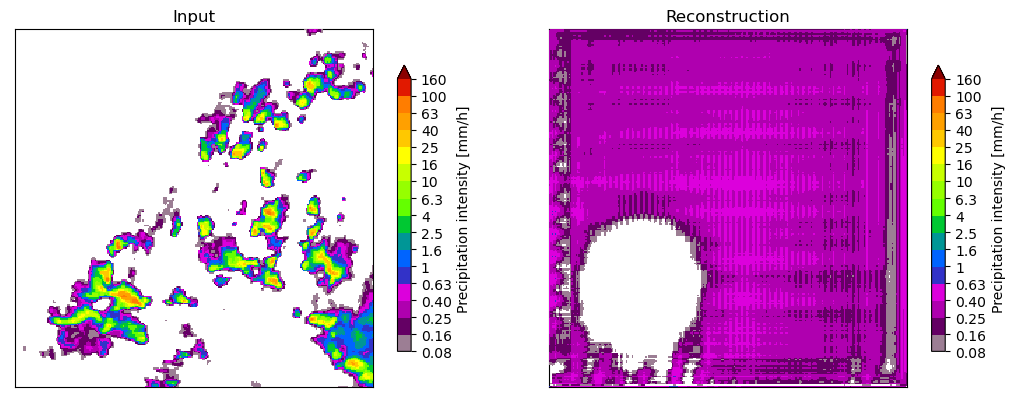

MSE: 18.342 MAE: 1.08 PCC: -0.19 
 CSI(1mm): 0.0 CSI(2mm): 0.0 CSI(8mm): 0.0 
 ACC(1mm): 0.897 ACC(2mm): 0.929 ACC(8mm): 0.973 
 FSS(1km): 0.4 FSS(10km): 0.381 FSS(20km): 0.359 FSS(30km): 0.33


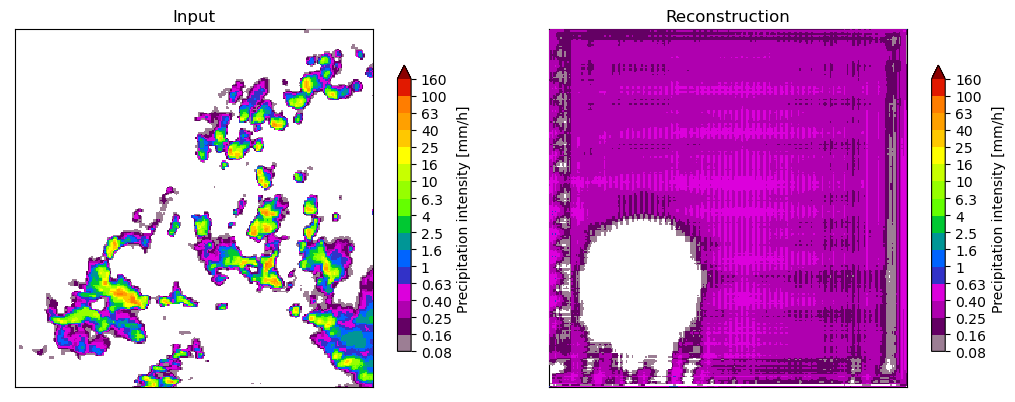

MSE: 5.285 MAE: 0.823 PCC: -0.291 
 CSI(1mm): 0.0 CSI(2mm): 0.0 CSI(8mm): 0.0 
 ACC(1mm): 0.836 ACC(2mm): 0.914 ACC(8mm): 0.989 
 FSS(1km): 0.504 FSS(10km): 0.486 FSS(20km): 0.466 FSS(30km): 0.441


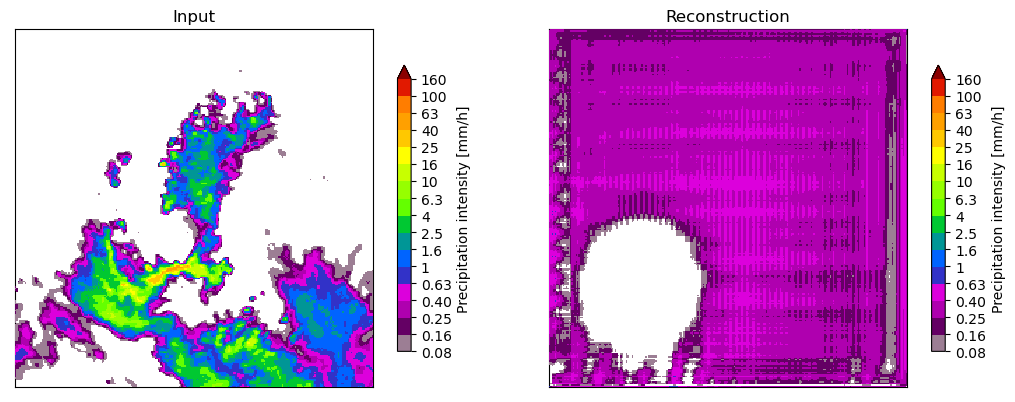

MSE: 17.87 MAE: 1.045 PCC: -0.187 
 CSI(1mm): 0.0 CSI(2mm): 0.0 CSI(8mm): 0.0 
 ACC(1mm): 0.911 ACC(2mm): 0.938 ACC(8mm): 0.973 
 FSS(1km): 0.352 FSS(10km): 0.334 FSS(20km): 0.315 FSS(30km): 0.29


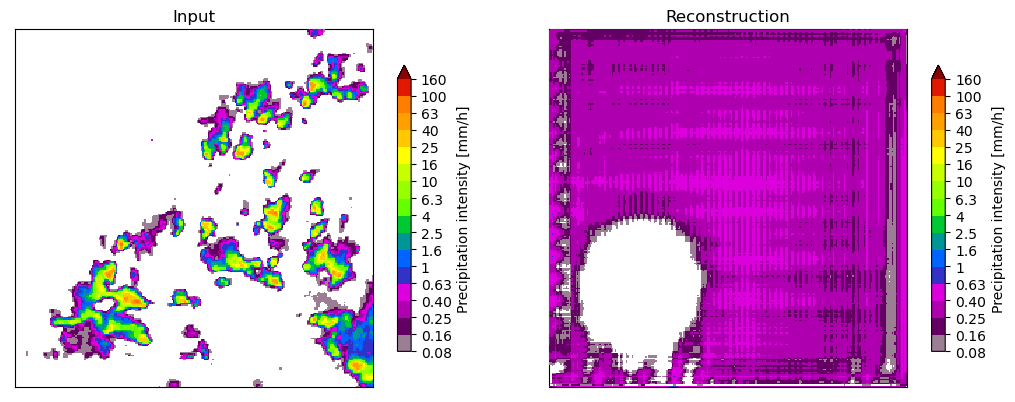

MSE: 16.538 MAE: 1.004 PCC: -0.17 
 CSI(1mm): 0.0 CSI(2mm): 0.0 CSI(8mm): 0.0 
 ACC(1mm): 0.916 ACC(2mm): 0.94 ACC(8mm): 0.974 
 FSS(1km): 0.341 FSS(10km): 0.324 FSS(20km): 0.305 FSS(30km): 0.281


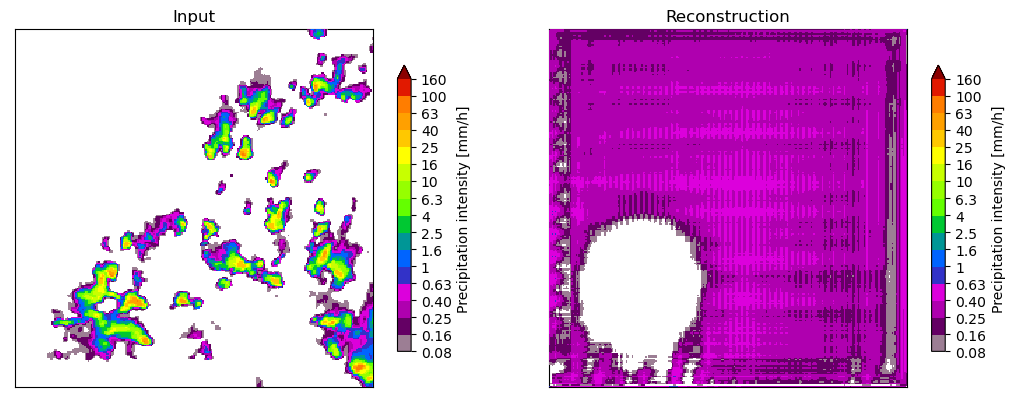

pcc_average: -0.20800000000000002


In [10]:
#torch.cuda.empty_cache()
import time
from pysteps.verification.detcatscores import det_cat_fct
from pysteps.verification.detcontscores import det_cont_fct
from pysteps.verification.spatialscores import intensity_scale
from pysteps.visualization import plot_precip_field
device = 'cuda:0'
pcc_average = 0
tokenizer=tokenizer.to(device)
for i, images in enumerate(loaders['test']):
    if i<0:continue
    if i>=5:break

    
    checkpoint = torch.load('/space/junzheyin/checkpoint/vqvae_checkpoint_epoch10', map_location=device)
    tokenizer.load_state_dict(checkpoint['model_state_dict'])
    
    image = images[0]
    image = image.unsqueeze(1)
    image = image[3:4, :, :, :]
    input_image= image.to(device)  # batch x
        #print(input_image.size())
    a_r = tokenizer.encode_decode(input_image)
        #checkpoint = torch.load('/users/zboucher/iris/src/models/tokenizer/vqvae_epoch70', map_location = 'cpu')
        #vae.load_state_dict(checkpoint)
        #a_r2 = vae(a)

    for t in range(1):
        a_display = a_r[t,0,:,:].to('cpu').detach().numpy()*40
        a_r_display = input_image[t,0,:,:].to('cpu').detach().numpy()*40
        
        scores_cat1 = det_cat_fct(a_r_display, a_display, 1)
        scores_cat2 = det_cat_fct(a_r_display, a_display, 2)
        scores_cat8 = det_cat_fct(a_r_display, a_display, 8)
        scores_cont = det_cont_fct(a_r_display, a_display, thr=0.1)
        
        scores_spatial = intensity_scale(a_r_display, a_display, 'FSS', 0.1, [1,10,20,30])
        pcc_average += float(np.around(scores_cont['corr_p'],3))
        if True:
            print('MSE:', np.around(scores_cont['MSE'],3), 
                    'MAE:', np.around(scores_cont['MAE'],3), 
                    'PCC:', np.around(scores_cont['corr_p'],3),'\n', 
                    'CSI(1mm):', np.around(scores_cat1['CSI'],3), # CSI: TP/(TP+FP+FN)
                    'CSI(2mm):', np.around(scores_cat2['CSI'],3),
                    'CSI(8mm):', np.around(scores_cat8['CSI'],3),'\n',
                    'ACC(1mm):', np.around(scores_cat1['ACC'],3), # ACC: (TP+TF)/(TP+TF+FP+FN)
                    'ACC(2mm):', np.around(scores_cat2['ACC'],3),
                    'ACC(8mm):', np.around(scores_cat8['ACC'],3),'\n',
                    'FSS(1km):', np.around(scores_spatial[0][0],3),
                    'FSS(10km):', np.around(scores_spatial[1][0],3),
                    'FSS(20km):', np.around(scores_spatial[2][0],3),
                    'FSS(30km):', np.around(scores_spatial[3][0],3)
                    )  
            plt.figure(figsize=(16, 4))
            plt.subplot(131)
            plot_precip_field(a_r_display, title="Input")
            plt.subplot(132)
            plot_precip_field(a_display, title="Reconstruction")
            
            plt.tight_layout()
            plt.show()
print('pcc_average:', pcc_average/i)

In [ ]:
print(input_image.shape)
print(images.shape)

In [ ]:
import numpy as np

# Load the NumPy array from file
array = np.load('/space/ankushroy/Tokeniser_Chkpts_recon_tokens_1024/metrices.npy', allow_pickle=True)

import matplotlib.pyplot as plt

metrics = array  # List of 79 metrics dictionaries

# Create lists to store the loss values
total_losses = []
commitment_losses = []
reconstruction_losses = []
perceptual_losses = []

# Extract the loss values from each metrics dictionary
for metric in metrics:
    total_losses.append(metric["<class '__main__.Tokenizer'>/train/total_loss"])
    commitment_losses.append(metric["tokenizer/train/commitment_loss"])
    reconstruction_losses.append(metric["tokenizer/train/reconstruction_loss"])
    perceptual_losses.append(metric["tokenizer/train/perceptual_loss"])

# Plot the losses
epochs = range(1, len(metrics) + 1)

plt.plot(epochs, total_losses, label='Total Loss')
#plt.plot(epochs, commitment_losses, label='Commitment Loss')
#plt.plot(epochs, reconstruction_losses, label='Reconstruction Loss')
#plt.plot(epochs, perceptual_losses, label='Perceptual Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.title('Losses over Epochs')
plt.legend()
plt.show()
